In [1]:
Notebook 2: Latent Feature Space with Clustering.ipynbimport pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data = load_wine()
target = load_wine().target
df = pd.DataFrame(data.data, columns=data.feature_names)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [3]:
data.data.shape

(178, 13)

In [4]:
num_epochs = 2000
batch_size = 16
dataset = torch.tensor(df_scaled, dtype=torch.float32)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input_dim = df.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

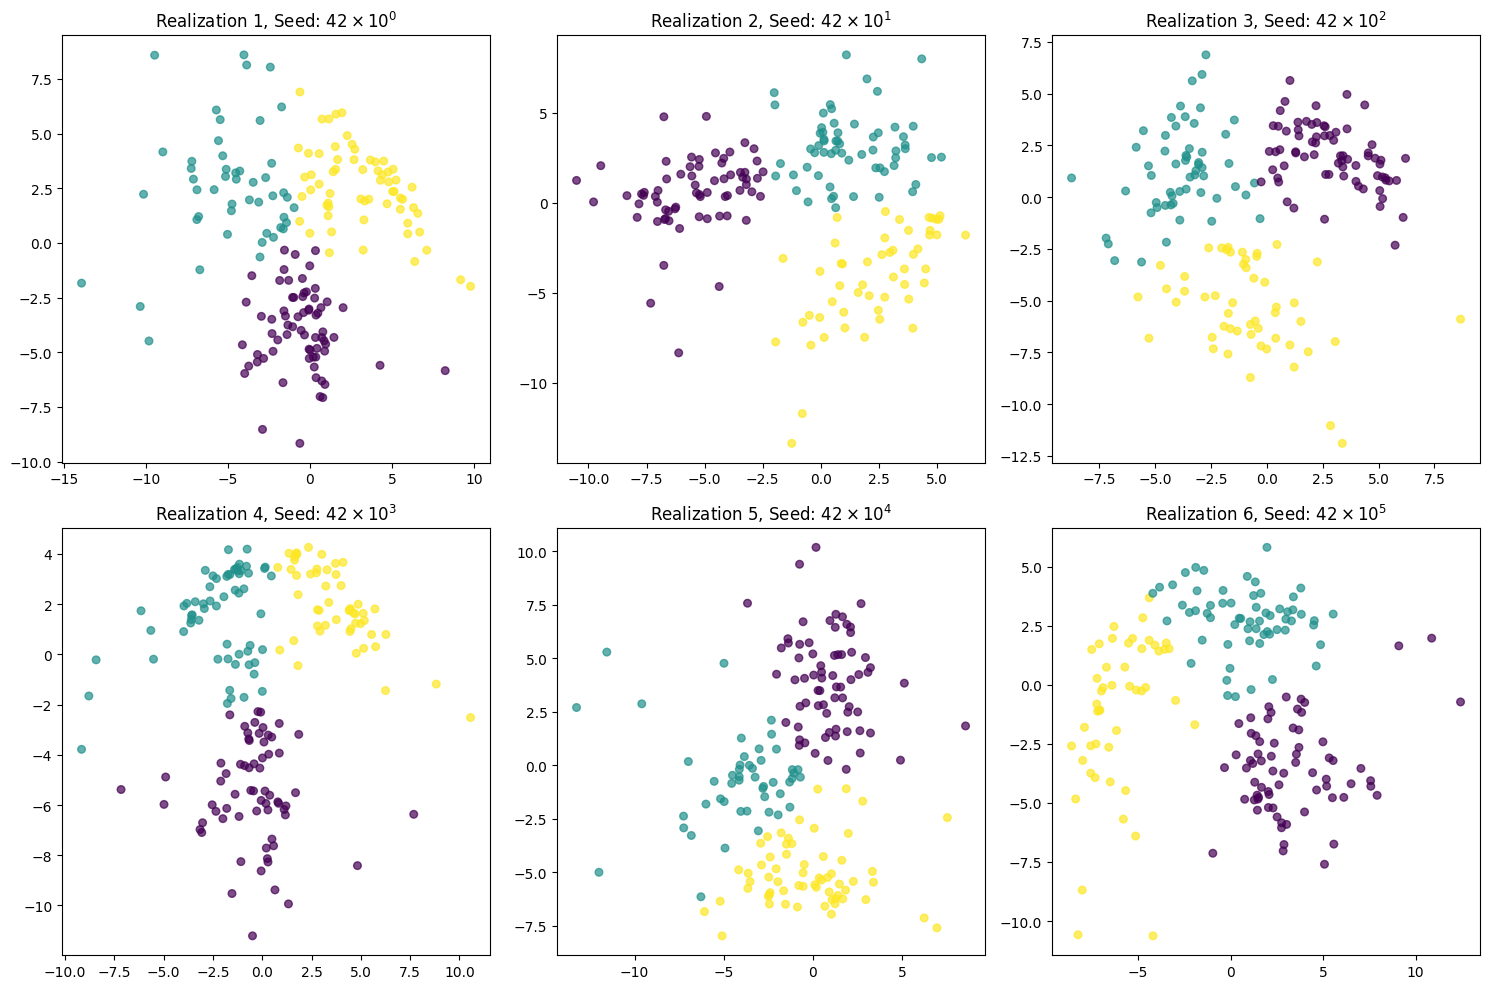

In [16]:
initial_seed = 42 # starting sequence for random seed generator
random.seed(initial_seed)
num_seeds = 6
seed_values = [initial_seed * (10 ** i) for i in range(num_seeds)]
cluster_changes = np.zeros_like(target)  # To track changes in cluster assignments

all_loss_curves = []

# Create a 3x3 grid for visualizations
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

change_percentages = []  # List to store percentage of changed clusters for each realization

for idx, seed in enumerate(seed_values):
    torch.manual_seed(seed)
    random.seed(seed)
    generator = torch.Generator().manual_seed(seed)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    model = Autoencoder(input_dim, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_losses.append(total_loss / len(dataloader))
    all_loss_curves.append(epoch_losses)


#     # Clustering in latent space
#     Here's a breakdown of how it works:
#
# 1. **Initialization**:
#    - `cluster_changes` is initialized as a zero array with the same shape as the `target` (truth labels). This means initially, all data points have 0 changes.
#    - `predicted_clusters` is computed for each realization after clustering in the latent space.
#
# 2. **Matching clusters with truth labels**:
#    - A cost matrix is computed to find the best correspondence between predicted clusters and the true labels.
#    - The Hungarian algorithm (`linear_sum_assignment`) is used to determine the optimal assignment.
#    - After the best assignment is determined, `predicted_clusters` labels are rearranged to match the true labels as closely as possible.
#
# 3. **Tracking changes**:
#    - For each data point, if its assigned cluster (`predicted_clusters`) doesn't match its true label (`target`), its corresponding value in `cluster_changes` is incremented by 1.
#    - This process is repeated for all 6 realizations.


    with torch.no_grad():
        encoded_data = model.encoder(dataset).numpy()

    kmeans = KMeans(n_clusters=3, n_init=10).fit(encoded_data)
    predicted_clusters = kmeans.labels_

    # Matching predicted clusters to true clusters
    cost_matrix = -np.array([[np.sum((predicted_clusters[true_indices] == pred_cluster))
                              for pred_cluster in range(3)]
                             for true_indices in [np.where(target == i)[0] for i in range(3)]])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    for i in range(3):
        predicted_clusters[predicted_clusters == col_ind[i]] = -(i+10)  # Temporarily set to negative values
    for i in range(3):
        predicted_clusters[predicted_clusters == -(i+10)] = i

    changes = (predicted_clusters != target)
    change_percentages.append(100 * np.sum(changes) / len(target))
    cluster_changes += changes

    # Visualization of latent space in 3x3 grid
    axs[idx].scatter(encoded_data[:, 0], encoded_data[:, 1], c=predicted_clusters, cmap='viridis', marker='o', s=30, alpha=0.7)
    axs[idx].set_title(f"Realization {idx+1}, Seed: $42 \\times 10^{idx}$")

plt.tight_layout()
plt.show()

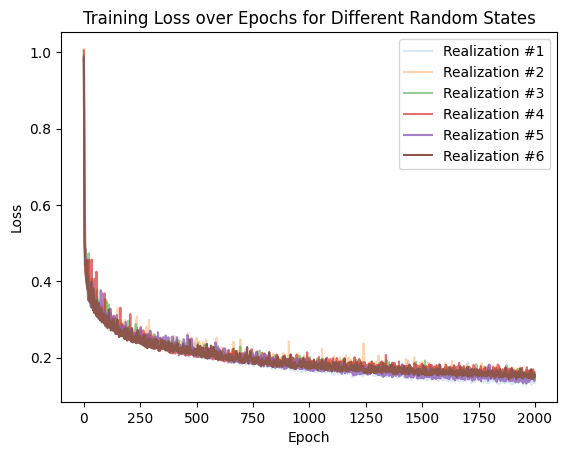

In [17]:
# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]
real_values = [1, 2, 3, 4, 5, 6]

for idx, losses in enumerate(all_loss_curves):
    # plt.plot(losses, label=f'Seed: {seed_values[idx]}', alpha=alphas[idx])
    plt.plot(losses, label=f'Realization #{real_values[idx]}', alpha=alphas[idx])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for Different Random States')
plt.legend()
plt.show()

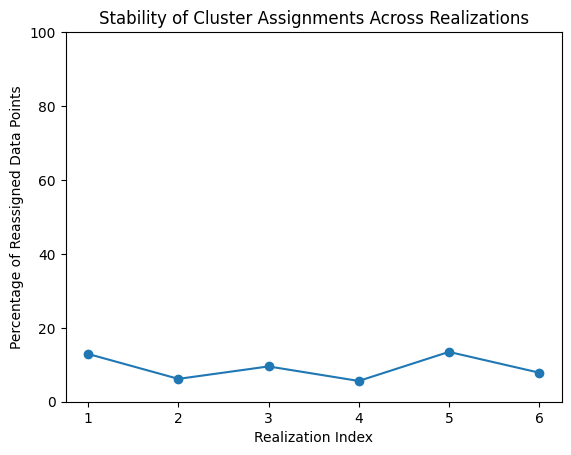

In [15]:
# Analyzing changes in cluster assignments using a line plot
plt.figure()
plt.plot(range(1, num_seeds+1), change_percentages, '-o')
plt.xlabel('Realization Index')
plt.ylabel('Percentage of Reassigned Data Points')
plt.title('Stability of Cluster Assignments Across Realizations')
plt.xticks(np.arange(1, num_seeds+1))
plt.ylim([0, 100])  # y-axis limits between 0 and 100 for percentages
plt.show()

Recall in each realization, we do the following:

1. Train an autoencoder, and then applying k-means to the latent space to identify clusters.
2. These clusters are then matched to the true labels to minimize the discrepancies between predicted and true cluster assignments.
3. After matching, for each data point, if the matched predicted cluster is different from its true label, it's considered a "change", and the corresponding entry in `cluster_changes` is incremented.

The `cluster_changes` array accumulates these "changes" for each data point over all realizations. After all realizations are done, the value for a data point in `cluster_changes` represents how many times (out of all realizations) the predicted cluster for that data point didn't match its true label. This becomes a tell-tale sign of stability in the latent feature space.